Fetching sensitive locations from Overpass API...
Parsing location data...
Saving sensitive locations to ../data/sensitive_location.csv...
Sensitive locations saved to ../data/sensitive_location.csv
Plotting sensitive areas on a map...
Map saved as sensitive_areas_map.html
Loading driving data...
Plotting histograms for Speed and Acceleration...


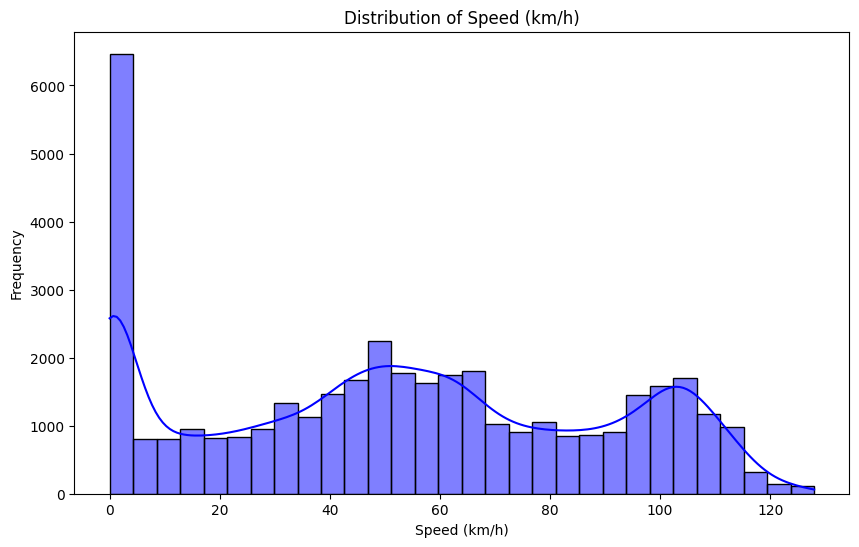

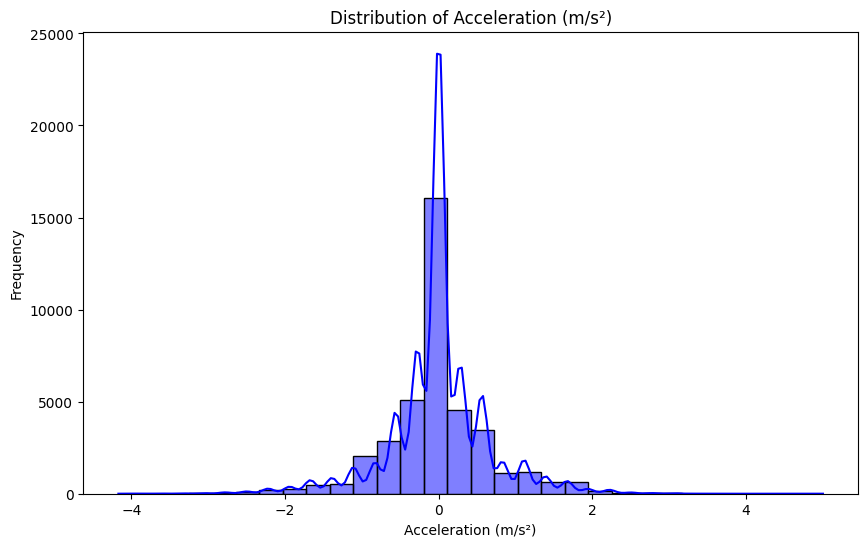

Process completed successfully.


In [3]:
import pandas as pd
import requests
import csv
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns

# Set boundaries for latitude and longitude based on your driving data
BOUNDARY_MIN_LAT = 39.96  # Adjust as per your driving_data.csv
BOUNDARY_MAX_LAT = 40.06  # Adjust as per your driving_data.csv
BOUNDARY_MIN_LON = -83.05  # Adjust as per your driving_data.csv
BOUNDARY_MAX_LON = -82.85  # Adjust as per your driving_data.csv

# Overpass API endpoint
OVERPASS_URL = "http://overpass-api.de/api/interpreter"

# Overpass query to fetch sensitive locations including schools, hospitals, libraries, etc.
overpass_query = f"""
[out:json];
(
  node["amenity"="school"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="hospital"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="college"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="university"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="nursing_home"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="library"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="police"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="fire_station"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
  node["amenity"="pharmacy"]({BOUNDARY_MIN_LAT},{BOUNDARY_MIN_LON},{BOUNDARY_MAX_LAT},{BOUNDARY_MAX_LON});
);
out center;
"""

def fetch_sensitive_locations():
    """Fetch sensitive locations from the Overpass API."""
    try:
        response = requests.post(OVERPASS_URL, data={'data': overpass_query})
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Overpass API: {e}")
        return None

def parse_locations(osm_data):
    """Parse the Overpass API JSON data and extract relevant location information."""
    locations = []
    for element in osm_data['elements']:
        lat = element['lat']
        lon = element['lon']
        amenity = element['tags'].get('amenity', 'Unknown')
        name = element['tags'].get('name', 'Unnamed')
        locations.append({
            'Latitude': lat,
            'Longitude': lon,
            'Amenity': amenity,
            'Name': name
        })
    return locations

def save_to_csv(locations, output_csv):
    """Save the parsed location data to a CSV file."""
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['Latitude', 'Longitude', 'Amenity', 'Name'])
        writer.writeheader()
        for location in locations:
            writer.writerow(location)
    print(f"Sensitive locations saved to {output_csv}")

def plot_sensitive_areas_on_map(locations, output_html):
    """Plot sensitive areas on an interactive map using Folium."""
    # Center the map at the first sensitive location
    if not locations:
        print("No locations found to plot.")
        return
    
    first_location = locations[0]
    folium_map = folium.Map(location=[first_location['Latitude'], first_location['Longitude']], zoom_start=12)
    
    # Use MarkerCluster to group markers
    marker_cluster = MarkerCluster().add_to(folium_map)
    
    for location in locations:
        popup_text = f"{location['Amenity'].title()}: {location['Name']}"
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            popup=popup_text,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)
    
    # Save map to HTML file
    folium_map.save(output_html)
    print(f"Map saved as {output_html}")

def plot_histogram(data, column, title, xlabel, ylabel):
    """Plot histogram of a specific column from the data."""
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=30, kde=True, color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def process_driving_data(input_csv, output_csv, output_map_html):
    """Main function to process driving data and fetch sensitive locations."""
    # Fetch sensitive locations from OSM
    print("Fetching sensitive locations from Overpass API...")
    osm_data = fetch_sensitive_locations()

    if osm_data:
        print("Parsing location data...")
        locations = parse_locations(osm_data)
        
        # Save sensitive locations to CSV
        print(f"Saving sensitive locations to {output_csv}...")
        save_to_csv(locations, output_csv)

        # Plot sensitive areas on a map with popups
        print("Plotting sensitive areas on a map...")
        plot_sensitive_areas_on_map(locations, output_map_html)

        # Load driving data and plot histograms for speed and acceleration
        print("Loading driving data...")
        df = pd.read_csv(input_csv)

        # Plot histograms for speed and acceleration
        print("Plotting histograms for Speed and Acceleration...")
        plot_histogram(df, 'Speed(km/h)', 'Distribution of Speed (km/h)', 'Speed (km/h)', 'Frequency')
        plot_histogram(df, 'Acceleration(m/s^2)', 'Distribution of Acceleration (m/s²)', 'Acceleration (m/s²)', 'Frequency')

        print("Process completed successfully.")
    else:
        print("Failed to retrieve sensitive locations.")

if __name__ == "__main__":
    input_csv = '../data/driving_data.csv'  # Path to your input driving data CSV file
    output_csv = '../data/sensitive_location.csv'  # Output CSV for sensitive areas
    output_map_html = 'sensitive_areas_map.html'  # Output HTML for map visualization

    # Process driving data and detect sensitive areas
    process_driving_data(input_csv, output_csv, output_map_html)
